In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [3]:
img = cv2.imread('images/color_image.jpg',0) #直接读为灰度图像
assert img.ndim == 2, 'img should be gray.'
rows,cols = img.shape[:2]
print('rows %s,cols %s' % (rows,cols))
#计算最优尺寸
nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print('nrows %s,ncols %s' % (nrows,ncols))
# 根据新尺寸，建立新变换图像
#nimg = np.zeros((nrows, ncols))
#nimg[:rows, :cols] = img
#print('nimg %s ' % nimg)
dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
# 换位，低频部分移到中间，高频部分移到四周
dft_shift  = np.fft.fftshift(dft)
# f = np.fft.fft2(img)
# fshift = np.fft.fftshift(f) # 快速傅里叶变换算法得到频率分布
# img_a = np.log(np.abs(fshift)) # fft 结果是复数，求绝对值结果才是振幅
# img_p = np.angle(fshift) # 取相位
# plt.subplot(131),plt.imshow(img,'gray'),plt.title('origin') 
# plt.subplot(132),plt.imshow(img_a,'gray'),plt.title('amplitude')
# plt.subplot(133),plt.imshow(img_p,'gray'),plt.title('phase')
# # plt.subplot(121),plt.imshow(f_a,'gray'),plt.title('振幅')
# # plt.subplot(122),plt.imshow(f_p,'gray'),plt.title('相位')

rows 987,cols 683
nrows 1000,ncols 720


In [4]:
def ifft(fft_mat):
    '''傅立叶反变换，返回反变换图像'''
    # 反换位，低频部分移到四周，高频部分移到中间
    f_ishift_mat = np.fft.ifftshift(fft_mat)
    # 傅立叶反变换
    img_back = cv2.idft(f_ishift_mat)
    # 将复数转换为幅度, sqrt(re^2 + im^2)
    img_back = cv2.magnitude(*cv2.split(img_back))
    # 标准化到0~255之间
    cv2.normalize(img_back, img_back, 0, 255, cv2.NORM_MINMAX)
    return np.uint8(np.around(img_back))

In [9]:
def fft_distances(m, n):
    '''
    计算m,n矩阵每一点距离中心的距离
    见《数字图像处理MATLAB版.冈萨雷斯》93页
    '''
    u = np.array([i if i<=m/2 else m-i for i in range(m)], dtype=np.float32)
    v = np.array([i if i<=m/2 else m-i for i in range(m)], dtype=np.float32)
    v.shape = n, 1
 
    # 每点距离矩阵左上角的距离
    ret = np.sqrt(u*u + v*v)
 
    # 每点距离矩阵中心的距离
    return np.fft.fftshift(ret)

In [12]:
def filter(flag, rows, cols, d0, n=1):
    '''
    低通滤波器
    @param flag: 滤波器类型
    0 - 理想低通滤波
    1 - 巴特沃兹低通滤波
    2 - 高斯低通滤波
    3 - 理想高通滤波
    4 - 巴特沃兹高通滤波
    5 - 高斯高通滤波
    @param rows: 被滤波的矩阵高度
    @param cols: 被滤波的矩阵宽度
    @param d0: 滤波器大小 D0
    @param n: 巴特沃兹低通滤波的阶数 
    @return 滤波器矩阵 
    '''

    filter_mat = None
    # 理想低通滤波
    if flag == 0:
        filter_mat = np.zeros((rows, cols, 2), np.float32)
        cv2.circle(filter_mat, (int(rows / 2), int(cols / 2)),d0, (1, 1, 1), thickness=-1)
    # 巴特沃兹低通滤波
    elif flag == 1: 
        duv = fft_distances(*dft_shift.shape[:2])
        filter_mat = 1 / (1+ np.power(duv/d0, 2*n)) 
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat =cv2.merge((filter_mat, filter_mat)) 
    #高斯低通滤波
    elif flag == 2: 
        duv = fft_distances(*fft_mat.shape[:2])
        filter_mat = np.exp(-(duv*duv) / (2*d0*d0))
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat = cv2.merge((filter_mat, filter_mat))   
    #理想高通滤波
    elif flag == 3: 
        filter_mat = np.ones((rows, cols ,2), np.float32)
        cv2.circle(filter_mat, (rows/2, cols/2) , d0, (0,0,0), thickness=-1)  
    # 巴特沃兹高通滤波
    elif flag == 4: 
        duv = fft_distances(rows, cols)
        # duv有 0 值(中心距离中心为0)， 为避免除以0，设中心为 0.000001
        duv[rows/2, cols/2] = 0.000001
        filter_mat = 1 / (1+ np.power(d0/duv, 2*n)) 
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat =cv2.merge((filter_mat, filter_mat)) 
    #高斯高通滤波
    else: 
        duv = fft_distances(*fft_mat.shape[:2])
        filter_mat = 1 - np.exp(-(duv*duv) / (2*d0*d0))
        # fft_mat有2个通道，实部和虚部
        # fliter_mat 也需要2个通道
        filter_mat = cv2.merge((filter_mat, filter_mat)) 
        
    #print('filter_mat %s'%filter_mat)
    return filter_mat

In [6]:
COF_5 = 5     # 截止频率 5
COF_50 = 50   # 截止频率 50
COF_150 = 150 # 截止频率 150
COF_250 = 250 # 截止频率 250
# 滤波器类型
FILTER_TYPE={
             'ILPF':0 , # 理想低通滤波器
             'BLPF':1,  # 巴特沃斯低通滤波器
             'GLPF':2,  # 高斯低通滤波器
             'IHPF':3 , # 理想高通滤波器
             'BHPF':4,  # 巴特沃斯高通滤波器
             'GHPF':5,  # 高斯高通滤波器
            }


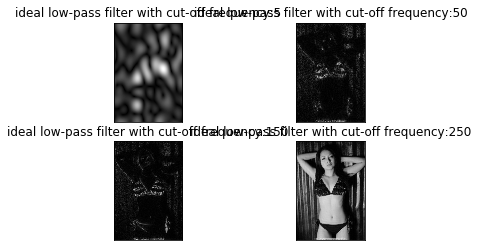

In [7]:
# 理想低通滤波器
ilpf_5 = filter(FILTER_TYPE['ILPF'],dft_shift.shape[0],dft_shift.shape[1],COF_5)
ilpf_50 = filter(FILTER_TYPE['ILPF'],dft_shift.shape[0],dft_shift.shape[1],COF_50)
ilpf_150 = filter(FILTER_TYPE['ILPF'],dft_shift.shape[0],dft_shift.shape[1],COF_150)
ilpf_250 = filter(FILTER_TYPE['ILPF'],dft_shift.shape[0],dft_shift.shape[1],COF_250)

filtered_mat5 = ilpf_5 * dft_shift # 进行滤波
img_back5 = ifft(filtered_mat5) # 反变换
filtered_mat50 = ilpf_50 * dft_shift
img_back50 = ifft(filtered_mat50)
filtered_mat150 = ilpf_150 * dft_shift
img_back150 = ifft(filtered_mat150)
filtered_mat250 = ilpf_250 * dft_shift
img_back250 = ifft(filtered_mat250)

plt.subplot(221),plt.imshow(img_back5, cmap = 'gray')
plt.title('ideal low-pass filter with cut-off frequency:5'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(img_back50, cmap = 'gray')
plt.title('ideal low-pass filter with cut-off frequency:50'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(img_back150, cmap = 'gray')
plt.title('ideal low-pass filter with cut-off frequency:150'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(img_back250, cmap = 'gray')
plt.title('ideal low-pass filter with cut-off frequency:250'), plt.xticks([]), plt.yticks([])
plt.show()

In [13]:
# 巴特沃斯低通滤波
ilpf_5 = filter(FILTER_TYPE['ILPF'],dft_shift.shape[0],dft_shift.shape[1],COF_5)
ilpf_50 = filter(FILTER_TYPE['BLPF'],dft_shift.shape[0],dft_shift.shape[1],COF_50)
ilpf_150 = filter(FILTER_TYPE['BLPF'],dft_shift.shape[0],dft_shift.shape[1],COF_150)
ilpf_250 = filter(FILTER_TYPE['BLPF'],dft_shift.shape[0],dft_shift.shape[1],COF_250)

filtered_mat5 = ilpf_5 * dft_shift # 进行滤波
img_back5 = ifft(filtered_mat5) # 反变换
filtered_mat50 = ilpf_50 * dft_shift
img_back50 = ifft(filtered_mat50)
filtered_mat150 = ilpf_150 * dft_shift
img_back150 = ifft(filtered_mat150)
filtered_mat250 = ilpf_250 * dft_shift
img_back250 = ifft(filtered_mat250)

plt.subplot(221),plt.imshow(img_back5, cmap = 'gray')
plt.title('Bath low-pass filter with cut-off frequency:5'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(img_back50, cmap = 'gray')
plt.title('Bath low-pass filter with cut-off frequency:50'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(img_back150, cmap = 'gray')
plt.title('Bath low-pass filter with cut-off frequency:150'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(img_back250, cmap = 'gray')
plt.title('Bath low-pass filter with cut-off frequency:250'), plt.xticks([]), plt.yticks([])
plt.show()

ValueError: cannot reshape array of size 987 into shape (683,1)

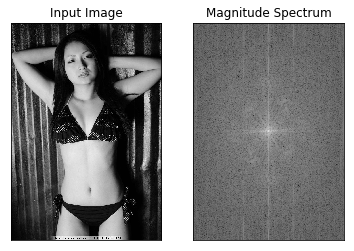

crow 493,ccol 341


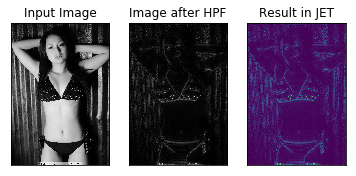

In [28]:
img = cv2.imread('images/color_image.jpg',0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
print('crow %s,ccol %s' % (crow,ccol))
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(131),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_back)
plt.title('Result in JET'), plt.xticks([]), plt.yticks([])

plt.show()